# s144259, Emil Strøm

### In collarboration with:
- s144277, Anders Melander
- s144246, Sophie Silberbrandt

# Credits
> This code is a slight modification to a translation (TensorFlow --> PyTorch) of a previous version of the [02456](http://kurser.dtu.dk/course/02456) course material. 
> [Original repo link (TensorFlow)](https://github.com/DeepLearningDTU/02456-deep-learning).
> [Translated repo link (PyTorch)](https://github.com/munkai/pytorch-tutorial/tree/master/2_intermediate).

In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

![MNIST.Example](../static_files/mnist.png)


## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [2]:
#!if [ ! -f mnist.npz ]; then wget -N https://github.com/maximai/placeholder_repo/raw/master/mnist.npz; else echo "mnist.npz already downloaded"; fi

In [3]:
#To speed up training we'll only work on a subset of the data
data = np.load('mnist.npz')
num_classes = 10
x_train = data['X_train'][:1000].astype('float32')
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
targets_test = data['y_test'][:500].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train (1000, 784)
targets_train (1000,)
x_valid (500, 784)
targets_valid (500,)
x_test (500, 784)
targets_test (500,)


In [4]:
data

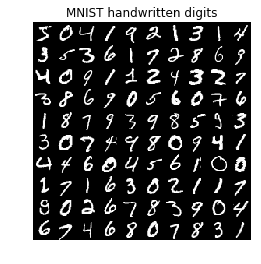

In [5]:
#plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Model

One of the large challenges in deep learning is the amount of hyperparameters that needs to be selected, and the lack of a good principled way of selecting them.
Hyperparameters can be found by experience (guessing) or some search procedure (often quite slow).
Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [Spearmint](https://github.com/JasperSnoek/spearmint) and many others.

**In practice a lot of trial and error is almost always involved.** This can be frustrating and time consuming, but the best thing to do is to think as a scientist, and go about it in a ordered manner --> monitor as much as you can, take notes, and be deliberate!

Below are some guidelines that you can use as a starting point to some of the most important hyperparameters. 
(*regularization* is also very important, but will be covered later.)


### Ballpark estimates of hyperparameters
__Number of hidden units and network structure:__
You'll have to experiment. One rarely goes below 512 units for feedforward networks (unless your are training on CPU...).
There's some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Parameter initialization:__
Parameter initialization is extremely important.
PyTorch has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaming He
2. Xavier Glorot
3. Uniform or Normal with small scale (0.1 - 0.01)
4. Orthogonal (this usually works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Mini-batch size:__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory, which means you can train a model with more parameters.

__Nonlinearity:__ [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
1. ReLU
2. Leaky ReLU
3. Elu
3. Sigmoid squash the output [0, 1], and are used if your output is binary (not used in the hidden layers)
4. Tanh is similar to sigmoid, but squashes in [-1, 1]. It is rarely used any more.
4. Softmax normalizes the the output to 1, and is used as output if you have a classification problem

See the plot below.

__Optimizer and learning rate:__
1. SGD + Momentum: learning rate 1.0 - 0.1 
2. ADAM: learning rate 3*1e-4 - 1e-5
3. RMSPROP: somewhere between SGD and ADAM


softmax should sum to one (approxiamtely): 1.0


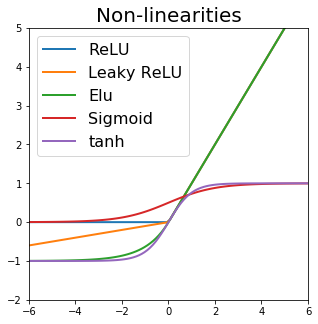

In [6]:
# Illustrate different output units
x = np.linspace(-6, 6, 100)
units = {
    "ReLU": lambda x: np.maximum(0, x),
    "Leaky ReLU": lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x),
    "Elu": lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1),
    "Sigmoid": lambda x: (1 + np.exp(-x))**(-1),
    "tanh": lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# assert that all class probablities sum to one
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))
print("softmax should sum to one (approxiamtely):", np.sum(softmax(x)))

In [7]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_hidden1, num_output):
        super(Net, self).__init__()  
        
        # input layer
        #self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features))) # Removed xavier init
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features))) # Added kaiming init
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        
        # Hidden layer 1
        #self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden1, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        
        # Hidden layer 2
        self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden1)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        
        # define activation function in constructor 
        # Changing from ELU to ReLU activation function
        #self.activation = torch.nn.ELU()
        self.activation = torch.nn.ReLU()
        
        
        # Adding dropout and batchnorm
        self.dropout = nn.Dropout()
        self.bn1 = nn.BatchNorm1d(num_features)
        self.bn2 = nn.BatchNorm1d(num_l1)

    def forward(self, x):
        # We have chosen to use batchnorm and dropout individually.
        
        #x = F.linear(self.dropout(x), self.W_1, self.b_1)
        x = F.linear(self.bn1(x), self.W_1, self.b_1) 
        x = self.activation(x)
        #x = F.linear(self.dropout(x), self.W_2, self.b_2)
        x = F.linear(self.bn2(x), self.W_2, self.b_2)
        x = self.activation(x)
        #x = F.linear(self.dropout(x), self.W_3, self.b_3)
        x = F.linear(self.bn2(x), self.W_3, self.b_3)
        return F.softmax(x, dim=1)


net = Net(num_features, num_l1, num_l2, num_classes)

In [8]:
#Different optimezers with different lr, etc.

#optimizer = optim.SGD(net.parameters(), lr=0.1)
#optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=3*1e-4, weight_decay = 1e-4)
optimizer = optim.Adam(net.parameters(), lr=3*1e-4)

criterion = nn.CrossEntropyLoss()

In [9]:
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())

torch.Size([45, 10])


# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

Epoch  1 : Train Loss 0.217762 , Train acc 0.546000, Valid acc 0.508000
Epoch 11 : Train Loss 0.150181 , Train acc 0.979000, Valid acc 0.832000
Epoch 21 : Train Loss 0.147476 , Train acc 0.990000, Valid acc 0.838000
Epoch 31 : Train Loss 0.146848 , Train acc 0.995000, Valid acc 0.838000
Epoch 41 : Train Loss 0.146551 , Train acc 0.996000, Valid acc 0.842000
Epoch 51 : Train Loss 0.146484 , Train acc 0.996000, Valid acc 0.842000
Epoch 61 : Train Loss 0.146282 , Train acc 0.998000, Valid acc 0.848000
Epoch 71 : Train Loss 0.146262 , Train acc 0.998000, Valid acc 0.848000
Epoch 81 : Train Loss 0.146250 , Train acc 0.998000, Valid acc 0.848000
Epoch 91 : Train Loss 0.146242 , Train acc 0.998000, Valid acc 0.848000
Epoch 100 : Train Loss 0.146144 , Train acc 0.999000, Valid acc 0.848000


(Text(0.5,0,'Updates'), Text(0,0.5,'Acc'))

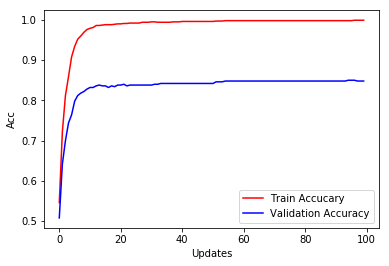

In [10]:
# we could have done this ourselves,
# but we should be aware of sklearn and it's tools
from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
           
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slce]))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0 or epoch == 99:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

In [11]:
# Adding a way to get the test accuracy

x_test_var = Variable(torch.from_numpy(x_test))
output_test = net(x_test_var)
preds = torch.max(output_test, 1)[1]
test_preds = list(preds.data.numpy())
test_acc = accuracy_score(list(targets_test), test_preds)

print("Test acc: %f" % (test_acc))


Test acc: 0.854000


# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on cleaver use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay) 
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code)
- add batchnorm

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    

# Results

## Initial settings
- Epoch  1 : Train Loss 0.228398 , Train acc 0.317000, Valid acc 0.308000
- Epoch 11 : Train Loss 0.189927 , Train acc 0.618000, Valid acc 0.578000
- Epoch 21 : Train Loss 0.180700 , Train acc 0.712000, Valid acc 0.660000
- Epoch 31 : Train Loss 0.176165 , Train acc 0.740000, Valid acc 0.690000
- Epoch 41 : Train Loss 0.169938 , Train acc 0.835000, Valid acc 0.746000
- Epoch 51 : Train Loss 0.166610 , Train acc 0.843000, Valid acc 0.752000
- Epoch 61 : Train Loss 0.164887 , Train acc 0.851000, Valid acc 0.760000
- Epoch 71 : Train Loss 0.163676 , Train acc 0.860000, Valid acc 0.760000
- Epoch 81 : Train Loss 0.161900 , Train acc 0.889000, Valid acc 0.754000
- Epoch 91 : Train Loss 0.156891 , Train acc 0.932000, Valid acc 0.814000
- Epoch 100 : Train Loss 0.155306 , Train acc 0.941000, Valid acc 0.822000

- Test acc: 0.836000

## Kaiming He initialization
- Epoch  1 : Train Loss 0.229416 , Train acc 0.202000, Valid acc 0.214000
- Epoch 11 : Train Loss 0.190634 , Train acc 0.613000, Valid acc 0.580000
- Epoch 21 : Train Loss 0.170548 , Train acc 0.854000, Valid acc 0.786000
- Epoch 31 : Train Loss 0.163511 , Train acc 0.888000, Valid acc 0.800000
- Epoch 41 : Train Loss 0.160374 , Train acc 0.910000, Valid acc 0.804000
- Epoch 51 : Train Loss 0.158349 , Train acc 0.924000, Valid acc 0.820000
- Epoch 61 : Train Loss 0.156799 , Train acc 0.935000, Valid acc 0.826000
- Epoch 71 : Train Loss 0.155653 , Train acc 0.941000, Valid acc 0.822000
- Epoch 81 : Train Loss 0.154781 , Train acc 0.945000, Valid acc 0.822000
- Epoch 91 : Train Loss 0.154084 , Train acc 0.950000, Valid acc 0.824000
- Epoch 100 : Train Loss 0.153554 , Train acc 0.952000, Valid acc 0.826000

- Test acc: 0.842000

After changing the initialization method we see little to no difference in the loss or either of the accuracies. 
And a very minor increase in test accuracy, this may just be due to random chance.

## Extra hidden layer
- Epoch  1 : Train Loss 0.227690 , Train acc 0.341000, Valid acc 0.312000
- Epoch 11 : Train Loss 0.169943 , Train acc 0.825000, Valid acc 0.754000
- Epoch 21 : Train Loss 0.161307 , Train acc 0.889000, Valid acc 0.790000
- Epoch 31 : Train Loss 0.156701 , Train acc 0.933000, Valid acc 0.820000
- Epoch 41 : Train Loss 0.154172 , Train acc 0.948000, Valid acc 0.826000
- Epoch 51 : Train Loss 0.152530 , Train acc 0.960000, Valid acc 0.826000
- Epoch 61 : Train Loss 0.151480 , Train acc 0.967000, Valid acc 0.828000
- Epoch 71 : Train Loss 0.150726 , Train acc 0.970000, Valid acc 0.828000
- Epoch 81 : Train Loss 0.150156 , Train acc 0.974000, Valid acc 0.828000
- Epoch 91 : Train Loss 0.149692 , Train acc 0.976000, Valid acc 0.826000
- Epoch 100 : Train Loss 0.149424 , Train acc 0.977000, Valid acc 0.834000

- Test acc: 0.858000

We added an aditional hidden layer with 512 nodes.

When adding an additional layer we expected the training accuracy grows as we increase the complexity of the model, thereby allowing the model to better fit the training data. The test accuracy increases from the previous two experiments suggesting that the model has improved without overfitting. 

## ReLU activation function
- Epoch  1 : Train Loss 0.228742 , Train acc 0.267000, Valid acc 0.230000
- Epoch 11 : Train Loss 0.178261 , Train acc 0.777000, Valid acc 0.710000
- Epoch 21 : Train Loss 0.165165 , Train acc 0.896000, Valid acc 0.788000
- Epoch 31 : Train Loss 0.157649 , Train acc 0.930000, Valid acc 0.826000
- Epoch 41 : Train Loss 0.154782 , Train acc 0.942000, Valid acc 0.840000
- Epoch 51 : Train Loss 0.153211 , Train acc 0.953000, Valid acc 0.844000
- Epoch 61 : Train Loss 0.152165 , Train acc 0.958000, Valid acc 0.854000
- Epoch 71 : Train Loss 0.151394 , Train acc 0.961000, Valid acc 0.854000
- Epoch 81 : Train Loss 0.150815 , Train acc 0.965000, Valid acc 0.852000
- Epoch 91 : Train Loss 0.150359 , Train acc 0.967000, Valid acc 0.850000
- Epoch 100 : Train Loss 0.150119 , Train acc 0.967000, Valid acc 0.850000

- Test acc: 0.860000

Due to the similarities between ELU and ReLU we expected minor changes in the results.


## Add momentum to SGD optimzer
- Epoch  1 : Train Loss 0.227679 , Train acc 0.342000, Valid acc 0.322000
- Epoch 11 : Train Loss 0.168088 , Train acc 0.788000, Valid acc 0.708000
- Epoch 21 : Train Loss 0.158484 , Train acc 0.886000, Valid acc 0.768000
- Epoch 31 : Train Loss 0.157347 , Train acc 0.890000, Valid acc 0.778000
- Epoch 41 : Train Loss 0.156796 , Train acc 0.893000, Valid acc 0.778000
- Epoch 51 : Train Loss 0.156664 , Train acc 0.893000, Valid acc 0.776000
- Epoch 61 : Train Loss 0.156593 , Train acc 0.893000, Valid acc 0.778000
- Epoch 71 : Train Loss 0.156480 , Train acc 0.894000, Valid acc 0.774000
- Epoch 81 : Train Loss 0.156424 , Train acc 0.894000, Valid acc 0.776000
- Epoch 91 : Train Loss 0.149183 , Train acc 0.975000, Valid acc 0.856000
- Epoch 100 : Train Loss 0.148264 , Train acc 0.981000, Valid acc 0.856000

- Test acc: 0.858000

We have chosen a low lr and a high momentum, to ensure we do not get stuck in local minima. 
(lr = 0.05, momentum = 0.9)
However as the test accuracy is basically the same as before we used momentum, it suggests that we do not get stuck in any local minima.

## Replacing SGD with Adam
- Epoch  1 : Train Loss 0.223096 , Train acc 0.576000, Valid acc 0.532000
- Epoch 11 : Train Loss 0.151788 , Train acc 0.969000, Valid acc 0.852000
- Epoch 21 : Train Loss 0.148643 , Train acc 0.979000, Valid acc 0.858000
- Epoch 31 : Train Loss 0.148254 , Train acc 0.980000, Valid acc 0.858000
- Epoch 41 : Train Loss 0.148067 , Train acc 0.981000, Valid acc 0.864000
- Epoch 51 : Train Loss 0.147675 , Train acc 0.985000, Valid acc 0.866000
- Epoch 61 : Train Loss 0.147544 , Train acc 0.986000, Valid acc 0.864000
- Epoch 71 : Train Loss 0.147518 , Train acc 0.986000, Valid acc 0.866000
- Epoch 81 : Train Loss 0.147509 , Train acc 0.986000, Valid acc 0.866000
- Epoch 91 : Train Loss 0.147502 , Train acc 0.986000, Valid acc 0.866000
- Epoch 100 : Train Loss 0.147495 , Train acc 0.986000, Valid acc 0.866000

- Test acc: 0.876000

We changed the optimization algorithm from SGD to Adam which improved the test accuracy by a bit. We expect Adam to converge faster, which can be seen in the training loss which barely changes from Epoch 51 to 100.




## Adding L2 regularization to Adam
- Epoch  1 : Train Loss 0.224036 , Train acc 0.555000, Valid acc 0.494000
- Epoch 11 : Train Loss 0.154090 , Train acc 0.954000, Valid acc 0.842000
- Epoch 21 : Train Loss 0.148644 , Train acc 0.980000, Valid acc 0.850000
- Epoch 31 : Train Loss 0.147957 , Train acc 0.984000, Valid acc 0.854000
- Epoch 41 : Train Loss 0.147731 , Train acc 0.986000, Valid acc 0.854000
- Epoch 51 : Train Loss 0.147512 , Train acc 0.987000, Valid acc 0.862000
- Epoch 61 : Train Loss 0.147484 , Train acc 0.987000, Valid acc 0.858000
- Epoch 71 : Train Loss 0.147382 , Train acc 0.988000, Valid acc 0.852000
- Epoch 81 : Train Loss 0.147373 , Train acc 0.988000, Valid acc 0.852000
- Epoch 91 : Train Loss 0.147368 , Train acc 0.988000, Valid acc 0.852000
- Epoch 100 : Train Loss 0.147303 , Train acc 0.989000, Valid acc 0.856000

- Test acc: 0.882000

When using regularization we restrict the size of the weights to help avoid overfitting. 

## Dropout 
- Epoch  1 : Train Loss 0.229565 , Train acc 0.352000, Valid acc 0.328000
- Epoch 11 : Train Loss 0.188169 , Train acc 0.707000, Valid acc 0.658000
- Epoch 21 : Train Loss 0.175198 , Train acc 0.834000, Valid acc 0.754000
- Epoch 31 : Train Loss 0.168680 , Train acc 0.883000, Valid acc 0.790000
- Epoch 41 : Train Loss 0.164025 , Train acc 0.916000, Valid acc 0.804000
- Epoch 51 : Train Loss 0.161548 , Train acc 0.931000, Valid acc 0.832000
- Epoch 61 : Train Loss 0.159589 , Train acc 0.939000, Valid acc 0.838000
- Epoch 71 : Train Loss 0.159165 , Train acc 0.944000, Valid acc 0.852000
- Epoch 81 : Train Loss 0.158877 , Train acc 0.947000, Valid acc 0.850000
- Epoch 91 : Train Loss 0.157262 , Train acc 0.951000, Valid acc 0.852000
- Epoch 100 : Train Loss 0.156000 , Train acc 0.958000, Valid acc 0.854000

- Test acc: 0.880000

We now introduce the dropout technique as a different way of regularizing the weights. This works by temporarily removing half of the hidden nodes in training. This method gave us similar results to L2 regularization.

## Batchnorm
- Epoch  1 : Train Loss 0.217762 , Train acc 0.546000, Valid acc 0.508000
- Epoch 11 : Train Loss 0.150181 , Train acc 0.979000, Valid acc 0.832000
- Epoch 21 : Train Loss 0.147476 , Train acc 0.990000, Valid acc 0.838000
- Epoch 31 : Train Loss 0.146848 , Train acc 0.995000, Valid acc 0.838000
- Epoch 41 : Train Loss 0.146551 , Train acc 0.996000, Valid acc 0.842000
- Epoch 51 : Train Loss 0.146484 , Train acc 0.996000, Valid acc 0.842000
- Epoch 61 : Train Loss 0.146282 , Train acc 0.998000, Valid acc 0.848000
- Epoch 71 : Train Loss 0.146262 , Train acc 0.998000, Valid acc 0.848000
- Epoch 81 : Train Loss 0.146250 , Train acc 0.998000, Valid acc 0.848000
- Epoch 91 : Train Loss 0.146242 , Train acc 0.998000, Valid acc 0.848000
- Epoch 100 : Train Loss 0.146144 , Train acc 0.999000, Valid acc 0.848000

- Test acc: 0.854000

We now try yet another way of regularization method, called Batchnorm. It seems to be slightly worse than the other two cases, however this is within the margin of error. 


# Book assignment 

## Sigmoid neurons simulating perceptrons, part I (Chapter 1)

The perceptrons are a way to decide which decision we should go for. It is given as 

\begin{equation}
  \text{Output} =\begin{cases}
    0, & \text{if $ \sum_{j} w_{j}x_{j} + b \leq 0 $}.\\
    1, & \text{if $ \sum_{j} w_{j}x_{j} + b > 0 $}.
  \end{cases}
\end{equation}

In the exercise we have to prove that the behavior of the network doesn't change if we multiply all the weights and the biases in the network by a positive constant c. If we muliply the expression of the perceptrons by a constant we get

\begin{equation}
\sum_{j} c\cdot w_{j}x_{j} + c \cdot b 
\end{equation}

From the above expression we are allowed to move a factorable constant outside of the summation. Thereby we get 

\begin{equation}
c \cdot \Big(\sum_{j} w_{j}x_{j} + b \Big) 
\end{equation}

Since $c>0$ the result will not change sign and therefore it will not affect the behavoir of the network.  


## Sigmoid neurons simulating perceptrons, part II (Chapter 1)

In this exercise we have to show that in the limit $c \rightarrow \infty$ the behavoir of the network of Sigmoid neurons is exactly the same as the network of perceptrons. From the book (eq. 4) we know that the Sigmoid function is given as 

\begin{equation}
\sigma = \frac{1}{1 + \exp \Big(\sum_{j} w_{j}x_{j} - b \Big)}
\end{equation}

where $z = (\sum_{j} w_{j}x_{j} + b)$. This means that for large values of z then $\sigma(z) \rightarrow 1$ and for large negative values $\sigma(z) \rightarrow 0$. If we use our knowledge from the previous question we end up having 

\begin{equation}
c \cdot \Big(\sum_{j} w_{j}x_{j} + b \Big) = c \cdot z
\end{equation}

If we apply this in the sigmoid function we get 

\begin{equation}
\sigma = \frac{1}{1 + \exp(-c \cdot z)}
\end{equation}

Thus, if we let $c \rightarrow \infty$ as described in the exercise and z remains positive then $\exp(-c \cdot z) \rightarrow 0$. Therefore we will only have 

\begin{equation}
\sigma(-c \cdot z) = \frac{1}{1+0} = 1
\end{equation}

If we instead let z be negative while $c \rightarrow \infty$ then $\exp(-c \cdot z) \rightarrow \infty$. Hence we will end up with the following expression: 

\begin{equation}
\sigma(-c \cdot z) = \frac{1}{1+ \infty} \approx 0
\end{equation}

Which is exactly the same as a network of perceptrons. 

The problem will occur in the special case where $z = 0$ thus $\sigma(c \cdot 0) = \sigma(0) = \frac{1}{2}$. However in a perceptron network we would have the output as 0 instead of $\frac{1}{2}$.


--------------
You are done for now. [Good job.](https://media1.tenor.com/images/0fd559b07f2174f9b8b7dbde7c5a67ca/tenor.gif)